# Mini-Proyecto 5



In [3]:
import time
import csv, nltk, re, os, shutil, sys, subprocess, re
from IPython.display import display, Markdown, Math, clear_output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk, re, os, io
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm.keras import TqdmCallback
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN
from tensorflow.keras.regularizers import l1
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
tf.get_logger().setLevel('ERROR')
nltk.download('stopwords')
nltk.download('wordnet')

try:
    import tensorflow_hub as hub
    import tensorflow_text as text
    import bert
    import contractions
    from official.nlp import optimization
except:
    print("Installing tf hub, tf text and nlp")
    subprocess.check_call([sys.executable, "-m", "pip", "install", 
                           "tensorflow-hub", "tensorflow-text", "nlp",
                           "tf-models-official", "bert-for-tf2", 
                           "sentencepiece", "contractions"])    

import tensorflow_hub as hub
import tensorflow_text as text
import contractions
from official.nlp import optimization
import bert

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
from google.colab import files
uploaded = files.upload()

In [4]:
df = pd.read_csv('IMDB_Dataset.csv', delimiter=',')
df.dropna(inplace=True)
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer() 

df_processed = df.copy()
def clean_syns(column):
  column = re.sub(r"http\S+", "", column)
  column = re.sub(r"www\.[-.a-z0-9_]+", "", column)
  column = re.sub("\S*\d\S*", "", column).strip()
  column = re.sub('[^A-Za-z]+', ' ', column)
  column = column.lower()
  column = " ".join([word for word in column.split() if word not in STOPWORDS])

  try:
    column = contractions.fix(column)
  except Exception as e: 
    display("_Error al encontrar el siguiente texto:")
    display(column)
    raise e
    
  column = " ".join([lemmatizer.lemmatize(word) for word in column.split()])

  return column

In [6]:
display(Markdown("_Lematizamos y depuramos un poco las sinopsis de las películas:_"))
display(Markdown("-------------"))
df_processed["review"] = df_processed["review"].apply(clean_syns)
df_processed

_Lematizamos y depuramos un poco las sinopsis de las películas:_

-------------

,review,sentiment
0,one reviewer mentioned watching oz episode hoo...,positive
1,wonderful little production br br filming tech...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake think zombie ...,negative
4,petter mattei love time money visually stunnin...,positive
...,...,...
49995,thought movie right good job creative original...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,catholic taught parochial elementary school nu...,negative
49998,going disagree previous comment side maltin on...,negative


In [7]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df_processed, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), "--", len(df_val))

Train and Test size 40000 -- 10000


In [8]:
df_val, df_test = train_test_split(df_val, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_val), "--", len(df_test))

Train and Test size 8000 -- 2000


In [9]:
y_train = df_train['sentiment']
y_train = np.array(list(map(lambda x: 1 if x=="positive" else 0, y_train)))

y_val = df_val['sentiment']
y_val = np.array(list(map(lambda x: 1 if x=="positive" else 0, y_val)))

y_test = df_test['sentiment']
y_test = np.array(list(map(lambda x: 1 if x=="positive" else 0, y_test)))

In [10]:
df_x_train = df_train['review']
df_x_val = df_val['review']
df_x_test = df_test['review']

df_y_train = y_train
df_y_val = y_val
df_y_test = y_test

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(df_x_train)


_Artículo más corto: 2 words._

_Artículo más largo: 627 words._

_Longitud media: 75.81 words (+- dv 52.97)._

_Mediana del tamaño del artículo (línea roja): 59.00 words._

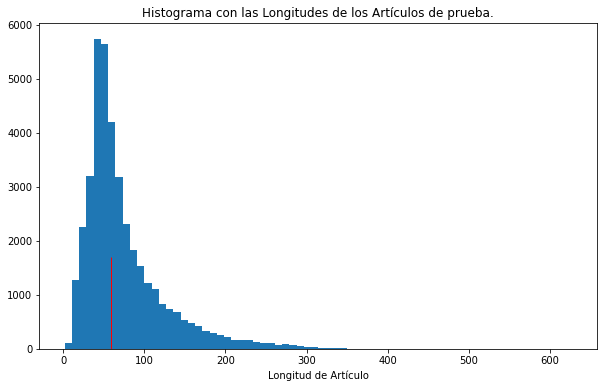

In [11]:
y_hist, x_hist = np.histogram(sorted(tokenizer.word_counts.values()), 100)
train_sequences = tokenizer.texts_to_sequences(df_x_train)
lengths = [len(seq) for seq in train_sequences]

x_train = pad_sequences(train_sequences, maxlen=128, padding='pre', 
                        truncating='post')

display(Markdown(f"_Artículo más corto: {np.min(lengths)} words._"))
display(Markdown(f"_Artículo más largo: {np.max(lengths)} words._"))
display(Markdown(f"_Longitud media: {np.mean(lengths):.2f} words (+- dv {np.std(lengths):.2f})._"))
display(Markdown(f"_Mediana del tamaño del artículo (línea roja): {np.median(lengths):.2f} words._"))

plt.figure(figsize=(10, 6))
plt.hist(lengths, 70)
plt.vlines(np.median(lengths), 0, 1700, colors="red", lw=1)
plt.title("Histograma con las Longitudes de los Artículos de prueba.")
plt.xlabel("Longitud de Artículo")
plt.show()

In [12]:
val_sequences = tokenizer.texts_to_sequences(df_x_val)
x_val = pad_sequences(val_sequences, maxlen=128, padding='pre', truncating='post')

test_sequences = tokenizer.texts_to_sequences(df_x_test)
x_test = pad_sequences(test_sequences, maxlen=128, padding='pre', truncating='post')

y_train_int = df_y_train
y_val_int = df_y_val
y_test_int = df_y_test

In [13]:
def int2binary(LABELS, num_classes):
  y = np.zeros((len(LABELS), num_classes), dtype='float32')

  for ind_lab, labels in enumerate(LABELS):
    y[ind_lab, labels-1] = 1      
  return y

In [14]:
y_train = int2binary(y_train_int, 2)
y_val = int2binary(y_val_int, 2)
y_test = int2binary(y_test_int, 2)

## LSTM model 1

_Número total de parámetros: 146,818._

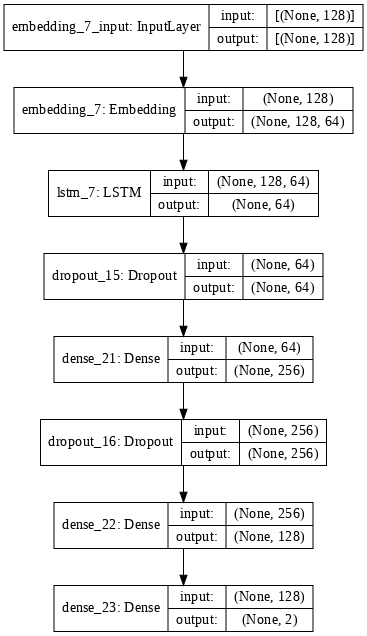

In [32]:
# Class weights
class_weights = 1 / y_train.sum(axis=0)
class_weights = class_weights / class_weights.sum()

# Samples weights
sample_weights = 10 * y_train.sum(axis=1) / 82

# Crea una red con layers Embedding, LSTM, Dense
model = Sequential()
model.add(Embedding(input_length=128, input_dim=1000, output_dim=64, trainable=True))
model.add(LSTM(units=64))
model.add(Dropout(0.6))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=2, activation=None))

display(Markdown(f"_Número total de parámetros: {model.count_params():3,}._"))
plot_model(model, 'model.png', dpi=72, rankdir="TB", show_shapes=True, 
           expand_nested=True)

In [34]:
start = time.time()
cbk = TqdmCallback()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer='adam', metrics=[tf.metrics.BinaryAccuracy()])
history = model.fit(x_train, y_train, epochs=20, batch_size=512, 
                    validation_data=(x_val, y_val), verbose=1,
                    callbacks=[cbk])

end = time.time()
print(end - start)

Epoch 1/20
79/79 [==============================] - 4s 28ms/step - loss: 0.2437 - binary_accuracy: 0.9018 - val_loss: 0.3677 - val_binary_accuracy: 0.8479
Epoch 2/20
79/79 [==============================] - 2s 22ms/step - loss: 0.2301 - binary_accuracy: 0.9066 - val_loss: 0.3751 - val_binary_accuracy: 0.8451
Epoch 3/20
79/79 [==============================] - 2s 21ms/step - loss: 0.2328 - binary_accuracy: 0.9058 - val_loss: 0.4077 - val_binary_accuracy: 0.8468
Epoch 4/20
79/79 [==============================] - 2s 22ms/step - loss: 0.2378 - binary_accuracy: 0.9035 - val_loss: 0.3856 - val_binary_accuracy: 0.8450
Epoch 5/20
79/79 [==============================] - 2s 21ms/step - loss: 0.2235 - binary_accuracy: 0.9116 - val_loss: 0.3973 - val_binary_accuracy: 0.8500
Epoch 6/20
79/79 [==============================] - 2s 21ms/step - loss: 0.2160 - binary_accuracy: 0.9136 - val_loss: 0.4187 - val_binary_accuracy: 0.8464
Epoch 7/20
79/79 [==============================] - 2s 22ms/step - los

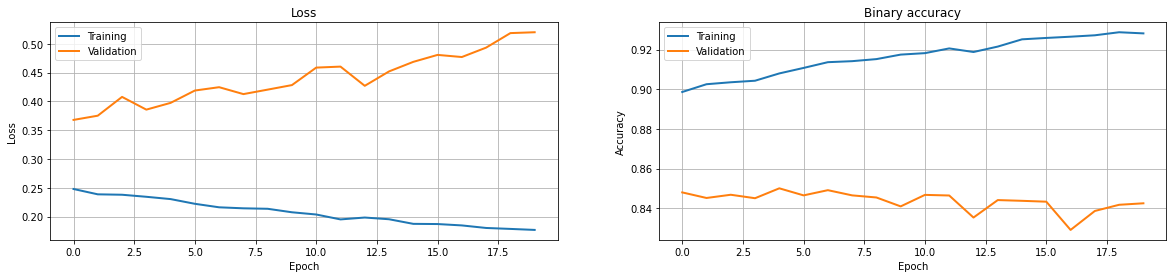

In [35]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Binary accuracy')
plt.plot(history.history['binary_accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_binary_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

## LSTM model 2

_Número total de parámetros: 26,626._

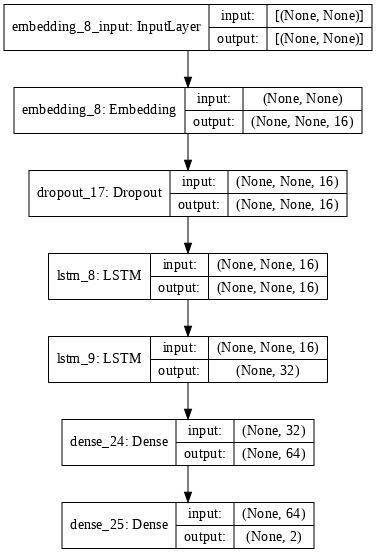

In [36]:
# Class weights
class_weights = 1 / y_train.sum(axis=0)
class_weights = class_weights / class_weights.sum()

# Samples weights
sample_weights = 10 * y_train.sum(axis=1) / 82

#Model 2 : Embedding, Dropout, 2 LSTM , 2 Dense
model = Sequential()
model.add(Embedding(input_dim=1000, output_dim=16))
model.add(Dropout(0.5))
model.add(LSTM(units=16, return_sequences=True))
model.add(LSTM(units=32))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=2, activation=None))

display(Markdown(f"_Número total de parámetros: {model.count_params():3,}._"))
plot_model(model, 'model.png', dpi=72, rankdir="TB", show_shapes=True, 
           expand_nested=True)

In [37]:
start = time.time()
cbk = TqdmCallback()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer='adam', metrics=[tf.metrics.BinaryAccuracy()])
history = model.fit(x_train, y_train, epochs=20, batch_size=512, 
                    validation_data=(x_val, y_val), verbose=1,
                    callbacks=[cbk])

end = time.time()
print(end - start)

Epoch 1/20
79/79 [==============================] - 5s 30ms/step - loss: 0.6516 - binary_accuracy: 0.5478 - val_loss: 0.3819 - val_binary_accuracy: 0.8298
Epoch 2/20
79/79 [==============================] - 2s 21ms/step - loss: 0.3810 - binary_accuracy: 0.8278 - val_loss: 0.3425 - val_binary_accuracy: 0.8478
Epoch 3/20
79/79 [==============================] - 2s 19ms/step - loss: 0.3535 - binary_accuracy: 0.8439 - val_loss: 0.3372 - val_binary_accuracy: 0.8522
Epoch 4/20
79/79 [==============================] - 2s 19ms/step - loss: 0.3298 - binary_accuracy: 0.8553 - val_loss: 0.3344 - val_binary_accuracy: 0.8516
Epoch 5/20
79/79 [==============================] - 2s 20ms/step - loss: 0.3281 - binary_accuracy: 0.8567 - val_loss: 0.3488 - val_binary_accuracy: 0.8465
Epoch 6/20
79/79 [==============================] - 2s 20ms/step - loss: 0.3271 - binary_accuracy: 0.8548 - val_loss: 0.3276 - val_binary_accuracy: 0.8562
Epoch 7/20
79/79 [==============================] - 2s 20ms/step - los

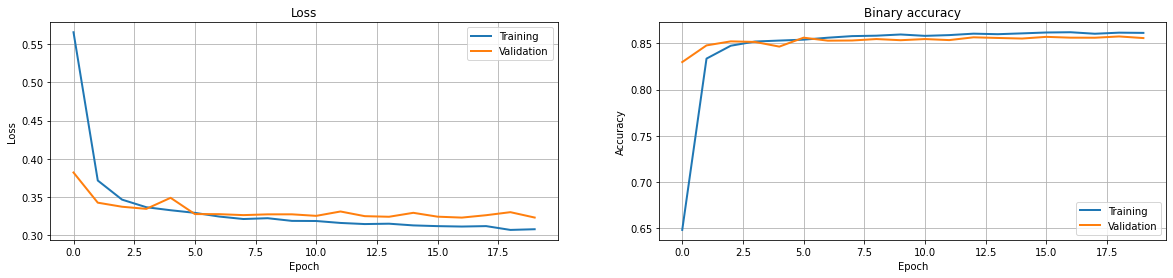

In [38]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Binary accuracy')
plt.plot(history.history['binary_accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_binary_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

## LSTM model 3

_Número total de parámetros: 54,978._

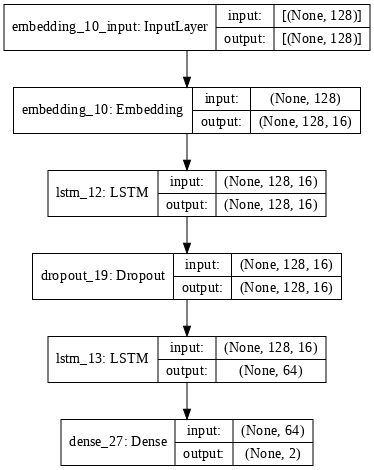

In [40]:
# Class weights
class_weights = 1 / y_train.sum(axis=0)
class_weights = class_weights / class_weights.sum()

# Samples weights
sample_weights = 10 * y_train.sum(axis=1) / 82

#Model 3 :  Embedding, Dropout, 1 LSTM , 1 Dense
model = Sequential()
model.add(Embedding(input_dim=2000, output_dim=16, input_length = 128))
model.add(LSTM(units=16, return_sequences=True))
model.add(Dropout(0.6))
model.add(LSTM(64))
model.add(Dense(units=2, activation=None))

display(Markdown(f"_Número total de parámetros: {model.count_params():3,}._"))
plot_model(model, 'model.png', dpi=72, rankdir="TB", show_shapes=True, 
           expand_nested=True)

In [42]:
start = time.time()
cbk = TqdmCallback()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer='adam', metrics=[tf.metrics.BinaryAccuracy()])
history = model.fit(x_train, y_train, epochs=20, batch_size=512, 
                    validation_data=(x_val, y_val), verbose=1,
                    callbacks=[cbk])

end = time.time()
print(end - start)

Epoch 1/20
79/79 [==============================] - 5s 33ms/step - loss: 0.6588 - binary_accuracy: 0.5383 - val_loss: 0.3949 - val_binary_accuracy: 0.8184
Epoch 2/20
79/79 [==============================] - 2s 23ms/step - loss: 0.3759 - binary_accuracy: 0.8307 - val_loss: 0.3509 - val_binary_accuracy: 0.8391
Epoch 3/20
79/79 [==============================] - 2s 22ms/step - loss: 0.3376 - binary_accuracy: 0.8504 - val_loss: 0.3496 - val_binary_accuracy: 0.8451
Epoch 4/20
79/79 [==============================] - 2s 22ms/step - loss: 0.3344 - binary_accuracy: 0.8517 - val_loss: 0.3502 - val_binary_accuracy: 0.8436
Epoch 5/20
79/79 [==============================] - 2s 23ms/step - loss: 0.3227 - binary_accuracy: 0.8563 - val_loss: 0.3348 - val_binary_accuracy: 0.8493
Epoch 6/20
79/79 [==============================] - 2s 23ms/step - loss: 0.3150 - binary_accuracy: 0.8588 - val_loss: 0.3444 - val_binary_accuracy: 0.8462
Epoch 7/20
79/79 [==============================] - 2s 23ms/step - los

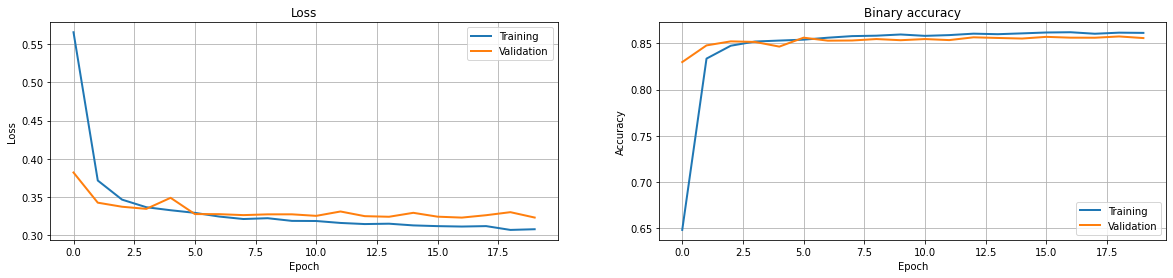

In [41]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Binary accuracy')
plt.plot(history.history['binary_accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_binary_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

 ## LSTM model 4

_Número total de parámetros: 18,162._

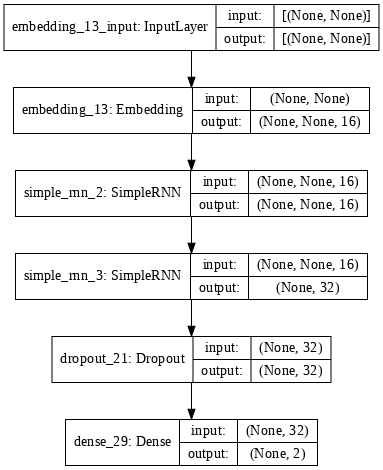

In [47]:
# Class weights
class_weights = 1 / y_train.sum(axis=0)
class_weights = class_weights / class_weights.sum()

# Samples weights
sample_weights = 10 * y_train.sum(axis=1) / 82

#Model 4 :  Embedding, 2 RNN, Dropout y Dense
model = Sequential()
model.add(Embedding(input_dim=1000, output_dim=16, trainable=True))
model.add(SimpleRNN(units=16, return_sequences=True))
model.add(SimpleRNN(units=32))
model.add(Dropout(0.6))
model.add(Dense(units=2, activation=None))

display(Markdown(f"_Número total de parámetros: {model.count_params():3,}._"))
plot_model(model, 'model.png', dpi=72, rankdir="TB", show_shapes=True, 
           expand_nested=True)

In [48]:
start = time.time()
cbk = TqdmCallback()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer='adam', metrics=[tf.metrics.BinaryAccuracy()])
history = model.fit(x_train, y_train, epochs=20, batch_size=512, 
                    validation_data=(x_val, y_val), verbose=1,
                    callbacks=[cbk])

end = time.time()
print(end - start)

Epoch 1/20
79/79 [==============================] - 19s 218ms/step - loss: 0.6927 - binary_accuracy: 0.5231 - val_loss: 0.4300 - val_binary_accuracy: 0.8112
Epoch 2/20
79/79 [==============================] - 16s 205ms/step - loss: 0.4328 - binary_accuracy: 0.8085 - val_loss: 0.3837 - val_binary_accuracy: 0.8284
Epoch 3/20
79/79 [==============================] - 16s 203ms/step - loss: 0.3604 - binary_accuracy: 0.8475 - val_loss: 0.3556 - val_binary_accuracy: 0.8468
Epoch 4/20
79/79 [==============================] - 16s 198ms/step - loss: 0.3388 - binary_accuracy: 0.8595 - val_loss: 0.3459 - val_binary_accuracy: 0.8502
Epoch 5/20
79/79 [==============================] - 16s 199ms/step - loss: 0.3327 - binary_accuracy: 0.8609 - val_loss: 0.3426 - val_binary_accuracy: 0.8509
Epoch 6/20
79/79 [==============================] - 16s 202ms/step - loss: 0.3222 - binary_accuracy: 0.8647 - val_loss: 0.3466 - val_binary_accuracy: 0.8484
Epoch 7/20
79/79 [==============================] - 16s 20

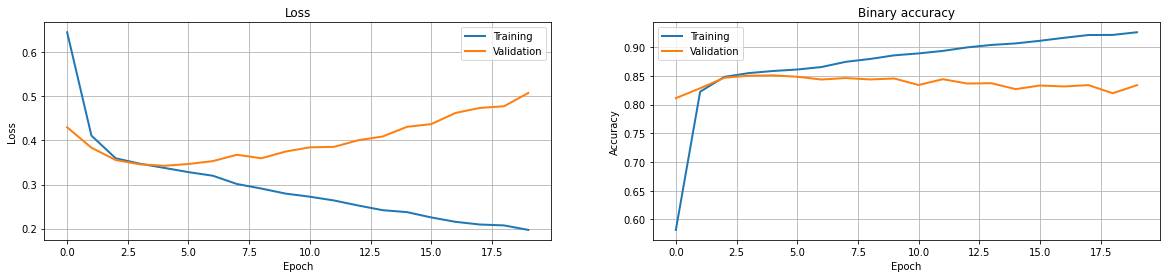

In [49]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Binary accuracy')
plt.plot(history.history['binary_accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_binary_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

## _BERT_1

In [16]:
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

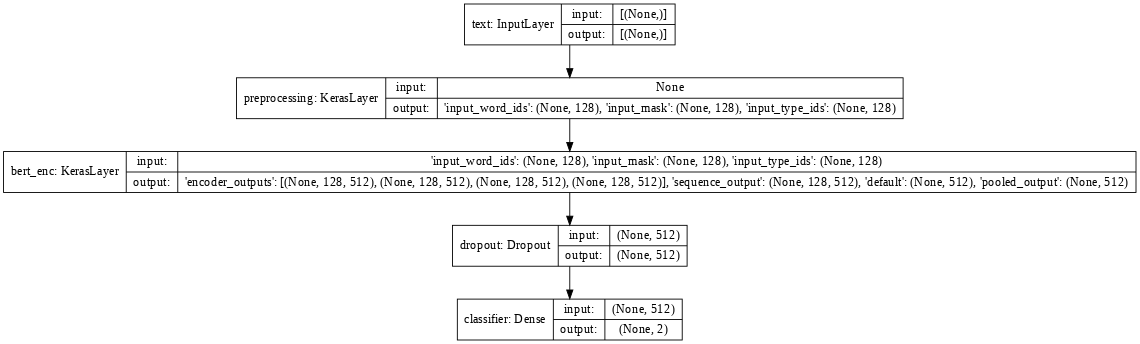

In [17]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessor = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='bert_enc')
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]
sequence_output = outputs["sequence_output"]

net = outputs['pooled_output']
net = tf.keras.layers.Dropout(0.1)(net)
net = tf.keras.layers.Dense(2, activation=None, name='classifier')(net)

classifier_model = tf.keras.Model(text_input, net)
tf.keras.utils.plot_model(classifier_model, show_shapes=True, 
                          show_layer_names=True, dpi=64, expand_nested=True)

In [22]:
start = time.time()
epochs = 2
steps_per_epoch = df_x_train.size/1000
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer='adam', metrics=[tf.metrics.BinaryAccuracy()])

cbk = TqdmCallback()
history = classifier_model.fit(x=df_x_train, y=y_train,
                               batch_size=16,
                               validation_data=(df_x_val, y_val), 
                               verbose=1, callbacks=[cbk], epochs=epochs)

NameError: ignored

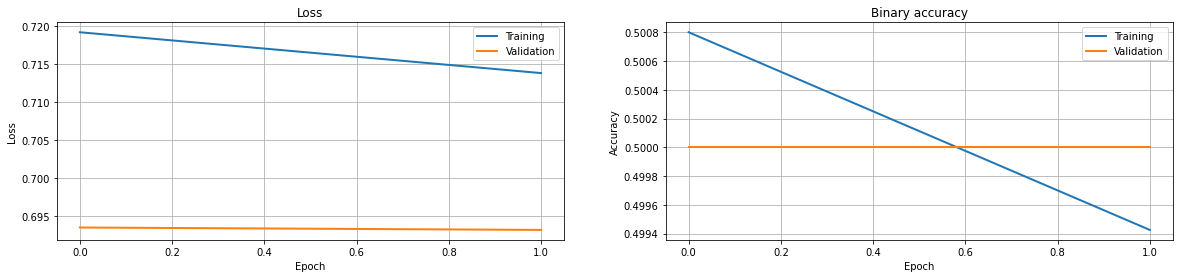

In [24]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Binary accuracy')
plt.plot(history.history['binary_accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_binary_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [30]:
print(classifier_model.history.history['loss'][-1])
print(classifier_model.history.history['val_loss'][-1])
print(classifier_model.evaluate(x=df_x_test, y=y_test, verbose=False))

KeyError: ignored

## _BERT con la Red Neuronal de LSTM_

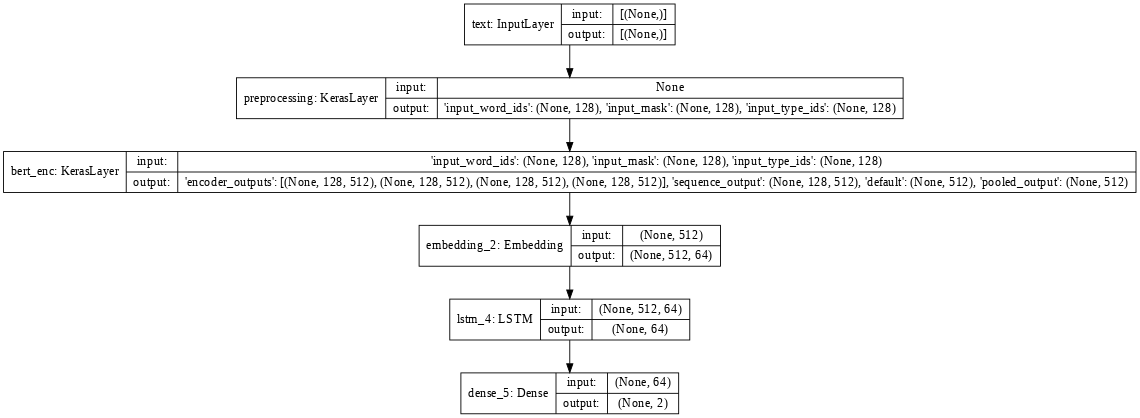

In [39]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessor = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='bert_enc')
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]
sequence_output = outputs["sequence_output"]

net = outputs['pooled_output']
net = Embedding(input_length=128, input_dim=112, output_dim=64, 
                trainable=True)(net)
net = LSTM(units=64)(net)
net = Dense(units=2, activation=None)(net)

classifier_model = tf.keras.Model(text_input, net)
tf.keras.utils.plot_model(classifier_model, show_shapes=True, 
                          show_layer_names=True, dpi=64, expand_nested=True)

In [41]:
start = time.time()
epochs = 2
steps_per_epoch = df_x_train.size/1000#1#tf.data.experimental.cardinality(x_train).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer='adam', metrics=[tf.metrics.BinaryAccuracy()])

cbk = TqdmCallback()
history = classifier_model.fit(x=df_x_train, y=y_train,
                               batch_size=128,
                               validation_data=(df_x_val, y_val), 
                               verbose=1, callbacks=[cbk], epochs=epochs)

end = time.time()
print(end - start)

Epoch 1/2
313/313 [==============================] - 311s 982ms/step - loss: 0.6933 - binary_accuracy: 0.5000 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 2/2
313/313 [==============================] - 311s 993ms/step - loss: 0.6932 - binary_accuracy: 0.5000 - val_loss: 0.6932 - val_binary_accuracy: 0.5000

621.7365498542786


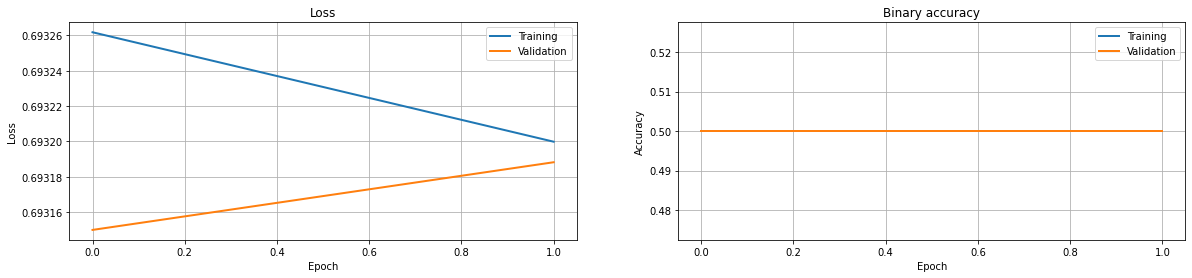

In [42]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Binary accuracy')
plt.plot(history.history['binary_accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_binary_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [43]:
print(classifier_model.history.history['loss'][-1])
print(classifier_model.history.history['val_loss'][-1])
print(classifier_model.evaluate(x=df_x_test, y=y_test, verbose=False))

0.6931998133659363
0.6931881904602051
[0.6931362748146057, 0.5]


## BERT con RRM

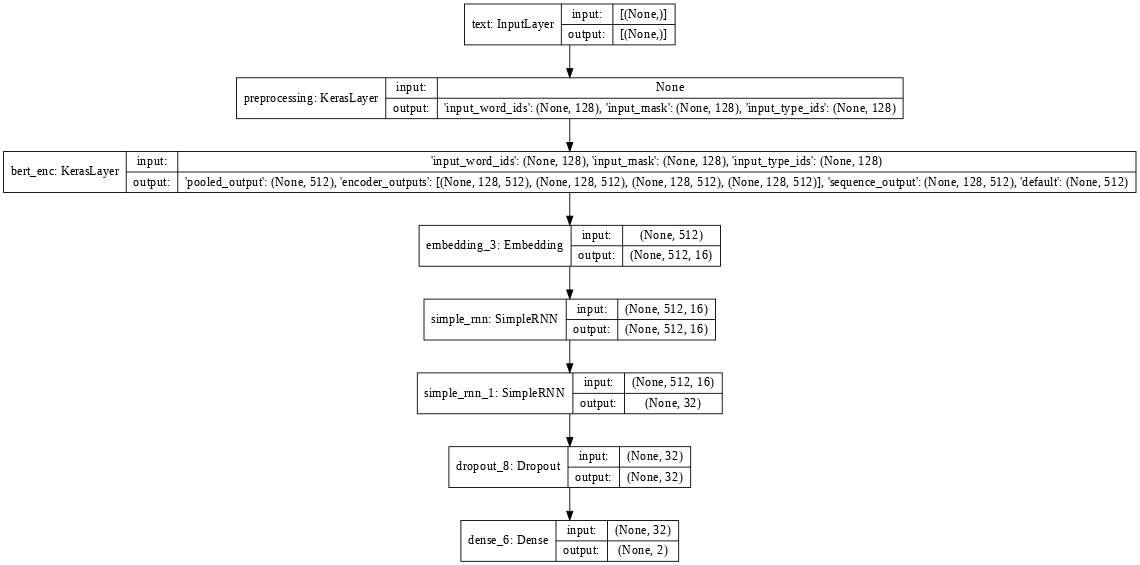

In [45]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessor = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='bert_enc')
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]
sequence_output = outputs["sequence_output"]

net = outputs['pooled_output']

net = Embedding(input_dim=1000, output_dim=16, trainable=True)(net)
net = SimpleRNN(units=16, return_sequences=True)(net)
net = SimpleRNN(units=32)(net)
net = Dropout(0.6)(net)
net = Dense(units=2, activation=None)(net)

classifier_model = tf.keras.Model(text_input, net)
tf.keras.utils.plot_model(classifier_model, show_shapes=True, 
                          show_layer_names=True, dpi=64, expand_nested=True)

In [46]:
start = time.time()
epochs = 2
steps_per_epoch = df_x_train.size/1000
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer='adam', metrics=[tf.metrics.BinaryAccuracy()])

cbk = TqdmCallback()
history = classifier_model.fit(x=df_x_train, y=y_train,
                               batch_size=128,
                               validation_data=(df_x_val, y_val), 
                               verbose=1, callbacks=[cbk], epochs=epochs)

end = time.time()
print(end - start)

Epoch 1/2
313/313 [==============================] - 562s 2s/step - loss: 0.6951 - binary_accuracy: 0.4997 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 2/2
313/313 [==============================] - 564s 2s/step - loss: 0.6935 - binary_accuracy: 0.5000 - val_loss: 0.6931 - val_binary_accuracy: 0.5000

1126.01446890831


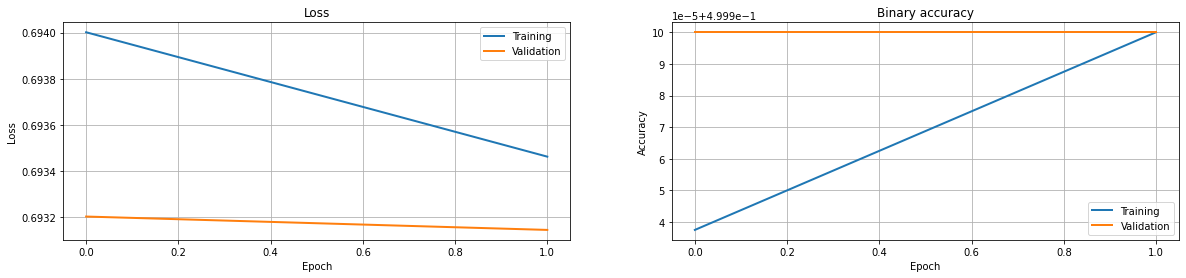

In [47]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Binary accuracy')
plt.plot(history.history['binary_accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_binary_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()